# Make a simple conv net from scratch in tensorflow

In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def random_batch(batch_size, X, Y):
    indices = np.random.randint(X.shape[0], size=batch_size)
    X_ = X[indices]
    y_ = Y[indices]
    return X_, y_

## Get data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
input_shape = mnist.train.images.shape
output_shape = mnist.train.labels.shape

In [5]:
input_shape

(55000, 784)

In [6]:
output_shape

(55000, 10)

## Try #1

In [83]:
name = "cnn_mnist_try01"
n_epochs = 2
batch_size = 10

In [74]:
model_dir = os.path.join('.', 'models', name)
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

tf.reset_default_graph()
tf.set_random_seed(101)

height = 28
width = 28
channels = 1
n_inputs = height * width

# Network architecture
with tf.name_scope("dnn"):
    # Inputs and outputs
    X_raw = tf.placeholder(tf.float32, shape=(None, input_shape[1]), name="X_raw")
    X_in = tf.reshape(X_raw, shape=[-1, height, width, channels])
    Y_raw = tf.placeholder(tf.int32, shape=(None), name="Y_raw")
    Y_in = tf.argmax(Y_raw, axis=1)
#     Y_in = tf.placeholder(tf.int32, shape=(None), name="Y_in")

    # Hidden layers
    c1 = tf.layers.conv2d(X_in, filters=30, kernel_size=7, padding="same", 
                          name="c1", activation=tf.nn.elu)
    c2 = tf.layers.conv2d(c1, 25, 5, padding="same", strides=2, 
                          name="c2", activation=tf.nn.elu)
    pool1 = tf.layers.max_pooling2d(c2, 10, strides=2, padding="same", 
                                    name="pool1")
    c3 = tf.layers.conv2d(pool1, 2, 2, padding="same", name="c3", 
                          activation=tf.nn.elu)
    
    # Flatten layers
    dim = c3.get_shape()
#     dim = tf.reduce_prod(tf.shape(c3)[1:])
    c3_flat = tf.reshape(c3, shape=[-1, dim[1]*dim[2]*dim[3]])

    output = tf.layers.dense(c3_flat, output_shape[1], activation=tf.nn.elu, 
                             name="output")
    y_prob = tf.nn.softmax(output, name="y_proba")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output, labels=Y_in)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(output, Y_in, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope("admin"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [ ]:
RESTORE = 0
n_batches = mnist.train.images.shape[0] // batch_size
print("Number of Batches per epoch: {}".format(n_batches))

def get_ckpt_name(epoch):
    return os.path.join(model_dir, name)+".ckpt{}".format(epoch)

global_train_num = 0
with tf.Session() as sess:
    sess.run(init)

    # Restore session
    if RESTORE >= 0:
        saver.restore(sess, get_ckpt_name(RESTORE))
        start_epoch = RESTORE + 1
    else:
        start_epoch = 0

    for epoch in range(start_epoch, n_epochs):

        # Run batches
        for batch_index in range(n_batches):
            X_batch, Y_batch = mnist.train.next_batch(batch_size)
            _, loss_val =                 sess.run([training_op, loss], 
                         feed_dict={X_raw: X_batch, Y_raw: Y_batch})
            global_train_num += 1
            
            if batch_index % 1000 == 0:
                print("Epoch {} Batch {}: loss={:.3e}".
                      format(epoch, batch_index,loss_val))

        # Run validation
        test_loss_val = sess.run(accuracy, feed_dict={X_raw: mnist.test.images, 
                                                      Y_raw: mnist.test.labels})

        # print summary
        if epoch % 10 == 0:
            saver.save(sess, get_ckpt_name(epoch))
            print("Epoch #{}:\tTrain Loss: {:.2e}\tTest Loss: {:.2e}".
                  format(epoch, loss_val, test_loss_val))

Number of Batches per epoch: 5500
INFO:tensorflow:Restoring parameters from .\models\cnn_mnist_try01\cnn_mnist_try01.ckpt0
Epoch 1 Batch 0: loss=9.510e-03
Epoch 1 Batch 1000: loss=5.857e-03
Epoch 1 Batch 2000: loss=6.561e-03
Epoch 1 Batch 3000: loss=3.685e-01
Epoch 1 Batch 4000: loss=3.820e-01
Epoch 1 Batch 5000: loss=2.289e-02


In [77]:
import matplotlib.pyplot as plt

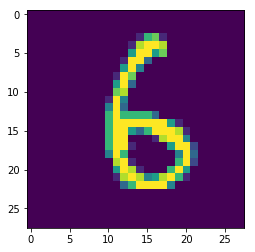

In [78]:
plt.imshow(mnist.test.images[3000].reshape(28, 28))
plt.show()

In [80]:
with tf.Session() as sess:
    saver.restore(sess, get_ckpt_name(0))
    result = sess.run(y_prob, feed_dict={X_raw: mnist.test.images[3000:3001]})

INFO:tensorflow:Restoring parameters from .\models\cnn_mnist_try01\cnn_mnist_try01.ckpt0


## Same thing but with keras for the layers

In [7]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import \
    Dense, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.python.keras.metrics import categorical_accuracy

In [10]:
tf.reset_default_graph()
X_raw = tf.placeholder(tf.float32, shape=(None, input_shape[1]), name="X_raw")
X_in = tf.reshape(X_raw, shape=[-1, 28, 28, 1])
Y_raw = tf.placeholder(tf.int32, shape=(None), name="Y_raw")
Y = tf.cast(Y_raw, tf.float32)
# Y_in = tf.argmax(Y_raw, axis=1)

c1 = Conv2D(32, kernel_size=(3,3),
            activation='elu')(X_in)
c2 = Conv2D(25, kernel_size=(3,3),
            activation='elu')(c1)
pool1 = MaxPooling2D(pool_size=(2, 2))(c2)
flat_conv = Flatten()(pool1)
dense1 = Dense(64, activation='elu')(flat_conv)
preds = Dense(10, activation='softmax')(dense1)

loss = tf.reduce_mean(categorical_crossentropy(Y, preds))
train_op = tf.train.AdamOptimizer().minimize(loss)
accuracy = tf.reduce_mean(categorical_accuracy(Y, preds))

with tf.Session() as sess:
    K.set_session(sess)
    
    sess.run(tf.global_variables_initializer())
    
    for i in range(500):
        X_batch, Y_batch = mnist.train.next_batch(50)
        _, l, a = sess.run([train_op, loss, accuracy], 
                          feed_dict={X_raw: X_batch, Y_raw: Y_batch})
        print("Batch: {} l={:.2e} a={:.2e}".format(i, l, a))
        
        if i % 100 == 0:
            X_batch, Y_batch = mnist.test.next_batch(500)
            l, a = sess.run([loss, accuracy], 
                          feed_dict={X_raw: X_batch, 
                                     Y_raw: Y_batch})
            print("\tTest {} l={}, a={}".format(i, l, a))

Batch: 0 l=2.39e+00 a=1.00e-01
	Test 0 l=2.2313125133514404, a=0.1979999989271164
Batch: 1 l=2.26e+00 a=1.60e-01
Batch: 2 l=2.07e+00 a=1.00e-01
Batch: 3 l=2.00e+00 a=3.20e-01
Batch: 4 l=1.95e+00 a=4.20e-01
Batch: 5 l=1.74e+00 a=5.00e-01
Batch: 6 l=1.70e+00 a=4.60e-01
Batch: 7 l=1.59e+00 a=6.40e-01
Batch: 8 l=1.47e+00 a=6.80e-01
Batch: 9 l=1.30e+00 a=7.00e-01
Batch: 10 l=1.17e+00 a=6.40e-01
Batch: 11 l=8.96e-01 a=8.00e-01
Batch: 12 l=8.23e-01 a=7.60e-01
Batch: 13 l=7.34e-01 a=7.60e-01
Batch: 14 l=8.87e-01 a=7.00e-01
Batch: 15 l=7.94e-01 a=7.00e-01
Batch: 16 l=6.95e-01 a=8.00e-01
Batch: 17 l=7.12e-01 a=8.00e-01
Batch: 18 l=5.19e-01 a=8.20e-01
Batch: 19 l=5.65e-01 a=8.40e-01
Batch: 20 l=4.58e-01 a=8.60e-01
Batch: 21 l=4.91e-01 a=8.40e-01
Batch: 22 l=3.90e-01 a=8.60e-01
Batch: 23 l=6.37e-01 a=8.20e-01
Batch: 24 l=5.41e-01 a=7.60e-01
Batch: 25 l=4.07e-01 a=8.40e-01
Batch: 26 l=7.85e-01 a=8.00e-01
Batch: 27 l=5.48e-01 a=8.00e-01
Batch: 28 l=5.16e-01 a=8.80e-01
Batch: 29 l=5.87e-01 a=7.80e-01

Batch: 248 l=3.20e-01 a=9.40e-01
Batch: 249 l=4.01e-01 a=9.00e-01
Batch: 250 l=5.47e-02 a=9.80e-01
Batch: 251 l=9.29e-02 a=9.60e-01
Batch: 252 l=3.98e-01 a=8.60e-01
Batch: 253 l=3.98e-01 a=9.40e-01
Batch: 254 l=1.83e-01 a=9.40e-01
Batch: 255 l=7.25e-02 a=9.80e-01
Batch: 256 l=1.89e-01 a=9.40e-01
Batch: 257 l=1.50e-01 a=9.60e-01
Batch: 258 l=3.48e-02 a=9.80e-01
Batch: 259 l=1.53e-01 a=9.80e-01
Batch: 260 l=2.27e-01 a=9.40e-01
Batch: 261 l=9.06e-02 a=9.80e-01
Batch: 262 l=1.45e-01 a=9.20e-01
Batch: 263 l=6.37e-02 a=9.80e-01
Batch: 264 l=1.50e-01 a=9.60e-01
Batch: 265 l=2.45e-01 a=9.60e-01
Batch: 266 l=3.99e-01 a=9.00e-01
Batch: 267 l=2.70e-01 a=9.60e-01
Batch: 268 l=1.38e-01 a=9.20e-01
Batch: 269 l=2.57e-01 a=9.40e-01
Batch: 270 l=6.14e-02 a=9.80e-01
Batch: 271 l=1.36e-01 a=9.60e-01
Batch: 272 l=2.91e-01 a=9.00e-01
Batch: 273 l=4.84e-02 a=1.00e+00
Batch: 274 l=4.22e-02 a=9.80e-01
Batch: 275 l=1.45e-01 a=9.40e-01
Batch: 276 l=1.80e-01 a=9.20e-01
Batch: 277 l=6.40e-02 a=9.80e-01
Batch: 278

Batch: 496 l=8.68e-02 a=9.60e-01
Batch: 497 l=1.29e-01 a=9.60e-01
Batch: 498 l=9.67e-02 a=9.80e-01
Batch: 499 l=4.86e-02 a=9.80e-01
